In [5]:
import datasets as ds

In [6]:
import pandas as pd

In [7]:
flores = ds.load_from_disk("data-bin/flores-dev-no-orth/")

In [8]:
ntrex = ds.load_from_disk("data-bin/ntrex-no-orth/")

### Create $\mathcal{D}_{\{\text{train, test}\}}$

In [9]:
finetune_langs = "deu,eng,est,nno,tur,ukr".split(",")
test_langs = "deu,eng,est,fin,kaz,nno,swe,ukr".split(",")

In [10]:
d_train = ds.concatenate_datasets([ntrex[lang] for lang in finetune_langs])

In [11]:
d_test = ds.concatenate_datasets([flores[lang] for lang in test_langs])

### Sanity check: language distribution

<Axes: title={'center': 'Language balance (train)'}>

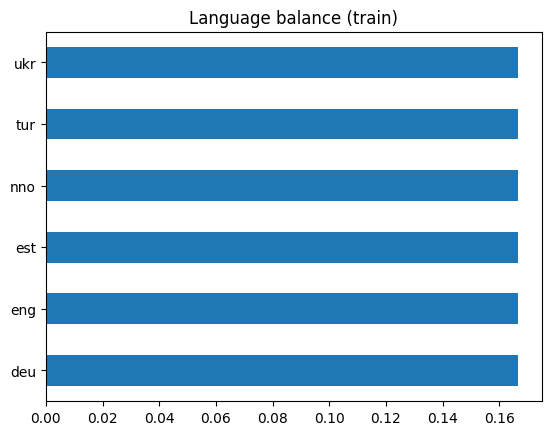

In [14]:
pd.value_counts(d_train['language'], normalize=True).plot(
    kind='barh', title='Language balance (train)')

<Axes: title={'center': 'Language balance (train)'}>

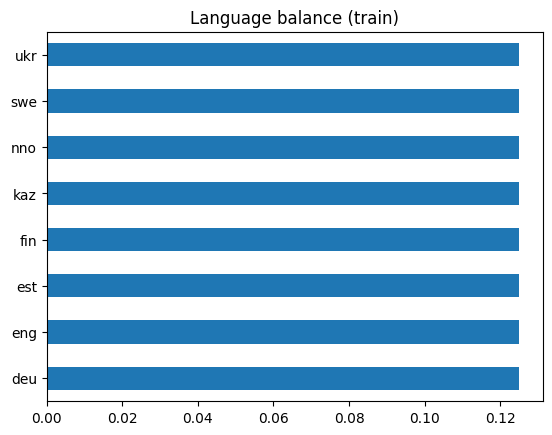

In [15]:
pd.value_counts(d_test['language'], normalize=True).plot(
    kind='barh', title='Language balance (train)')

## Baseline: bigram bag-of-words/chars

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

In [17]:
bow_vec = CountVectorizer(ngram_range=(2,2))
char_vec = CountVectorizer(analyzer='char', ngram_range=(2,2))

In [18]:
sentences_train = d_train['text']
sentences_test = d_test['text']

In [19]:
X_train_word = bow_vec.fit_transform(sentences_train)
X_train_char = char_vec.fit_transform(sentences_train)

In [20]:
    X_test_word = bow_vec.transform(sentences_test)
    X_test_char = char_vec.transform(sentences_test)

In [48]:
y_train = d_train['language']
y_test = d_test['language']

#### Bag of words

In [22]:
from sklearn.linear_model import LogisticRegression

In [26]:
bow_model = LogisticRegression(max_iter=1000)

In [28]:
bow_model = bow_model.fit(X_train_word, y_train)

In [43]:
y_pred = bow_model.predict(X_test_word)
y_pred_proba = bow_model.predict_proba(X_test_word)

In [62]:
lang_names = set(y_train) | set(y_test)

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [60]:
ConfusionMatrixDisplay?

In [82]:
def plot_confusion_matrix(clf, X_test, y_test, class_names):
    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

    plt.show()

Text(0.5, 1.0, 'Features: Word bigrams\nModel: Logistic regression')

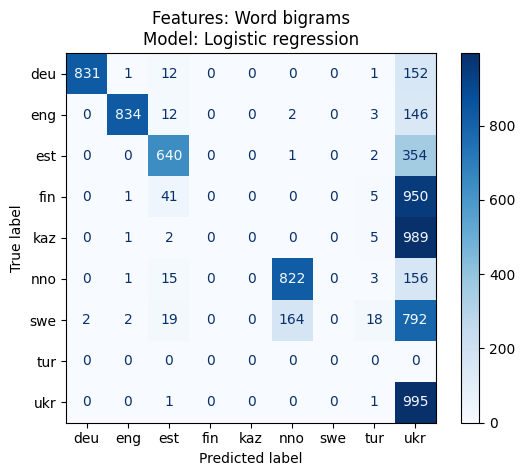

In [273]:
ConfusionMatrixDisplay.from_estimator(
        bow_model,
        X_test_word,
        y_test,
        display_labels=sorted(set(finetune_langs) | set(test_langs)),
        cmap=plt.cm.Blues,
        normalize=None,
        values_format='',
)
plt.title("Features: Word bigrams\nModel: Logistic regression")

#### Bag-of-chars

In [72]:
boc_model = LogisticRegression(max_iter=1000)

In [73]:
boc_model = boc_model.fit(X_train_char, y_train)

In [74]:
y_pred_char = boc_model.predict(X_test_char)
y_pred_proba_char = boc_model.predict_proba(X_test_char)

Text(0.5, 1.0, 'Features: Char bigrams\nModel: Logistic regression')

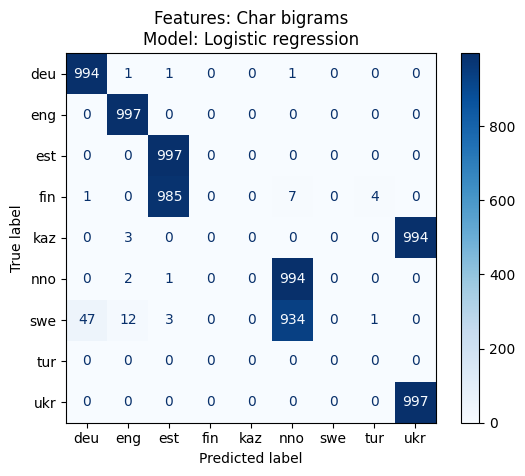

In [272]:
ConfusionMatrixDisplay.from_estimator(
        boc_model,
        X_test_char,
        y_test,
        display_labels=sorted(set(finetune_langs) | set(test_langs)),
        cmap=plt.cm.Blues,
        normalize=None,
        values_format='',
)
plt.title('Features: Char bigrams\nModel: Logistic regression')

In [275]:
print(set(test_langs)- set(finetune_langs))

{'fin', 'swe', 'kaz'}


## What if we use the XLM-R tokenizer?

To make the comparison maximally similar we can actually tokenize the sentences using XLM-Rs own tokenizer.

In [140]:
from transformers import AutoTokenizer

In [141]:
xlmr_tok = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [142]:
sentences_train_xlmr = [xlmr_tok.tokenize(sent) for sent in sentences_train]
sentences_test_xlmr = [xlmr_tok.tokenize(sent) for sent in sentences_test]

In [143]:
def no_op(x):
    return x

In [144]:
xlmr_vectorizer = CountVectorizer(
    ngram_range=(2,2), analyzer='word', 
    tokenizer=no_op, preprocessor=None, lowercase=False
)

In [145]:
X_train_xlmr = xlmr_vectorizer.fit_transform(sentences_train_xlmr)
X_test_xlmr = xlmr_vectorizer.transform(sentences_test_xlmr)

In [146]:
bag_of_xlmr_tok_model = LogisticRegression(max_iter=1000)

In [148]:
bag_of_xlmr_tok_model.fit(X_train_xlmr, y_train)

LogisticRegression(max_iter=1000)

In [151]:
y_pred_xlmr = bag_of_xlmr_tok_model.predict(X_test_xlmr)
y_pred_proba_xlmr = bag_of_xlmr_tok_model.predict_proba(X_test_xlmr)

Text(0.5, 1.0, 'Features: XLM-R token bigrams\nModel: Logistic regression')

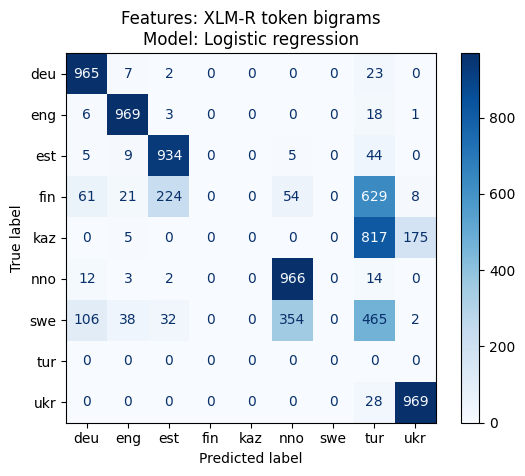

In [271]:
ConfusionMatrixDisplay.from_estimator(
        bag_of_xlmr_tok_model,
        X_test_xlmr,
        y_test,
        display_labels=sorted(set(finetune_langs) | set(test_langs)),
        cmap=plt.cm.Blues,
        normalize=None,
        values_format='',
)
plt.title("Features: XLM-R token bigrams\nModel: Logistic regression")

#### XLM_R confusion matrix from prospectus

In [308]:
rows = [
    ('deu', 997, *(5*[0])),
    ('eng', 0, 997, *(4*[0])),
    ('est', 0, 0, 997, *(3*[0])),
    ('fin', 0, 0, 997, *(3*[0])),
    ('kaz', *(4*[0]), 986, 11),
    ('nno', *(3*[0]), 997, *(2*[0])),
    ('swe', *(3*[0]), 997, *(2*[0])),
    ('ukr', *(5*[0]), 997),
]

In [309]:
xlmr_confusion_matrix = pd.DataFrame.from_records(
    rows, 
    columns=['true_label','deu', 'eng', 'est', 'nno', 'tur', 'ukr']).set_index('true_label')

In [310]:
import itertools as it

In [311]:
def flatten(nested):
    return list(it.chain.from_iterable(nested))

In [312]:
def convert_dict_to_preds(d):
    return flatten([v*[k] for k,v in d.items()])

In [313]:
xlmr_confusion_matrix.columns.name = 'predicted_label'

In [314]:
xlmr_confusion_matrix = xlmr_confusion_matrix.stack().reset_index()
xlmr_confusion_matrix.rename(columns={0: 'num_obs'}, inplace=True)

In [316]:
xlmr_trues = []
xlmr_preds = []

# _xlmr_preds = {l: convert_dict_to_preds(d) for l, d in xlmr_confusion_matrix.to_dict().items()}

In [319]:
for ix, row in xlmr_confusion_matrix.iterrows():
    for _ in range(row.num_obs):
        xlmr_preds.append(row.predicted_label)
        xlmr_trues.append(row.true_label)

In [320]:
# for lang, preds in _xlmr_preds.items():
#     n = len(preds)
#     xlmr_trues.extend(n*[lang])
#     xlmr_preds.extend(preds)

Text(0.5, 1.0, 'Features: XLM-R full encoder\nModel: XLM-R Classification head')

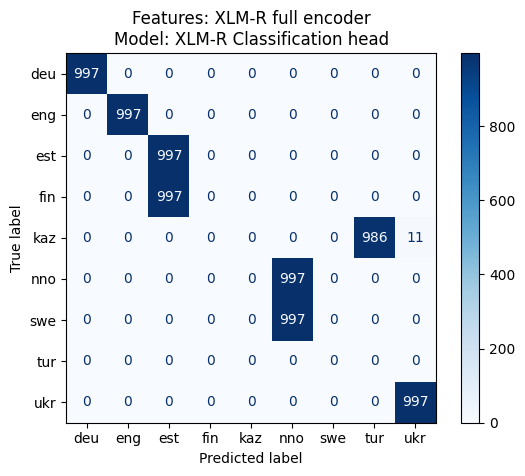

In [321]:
ConfusionMatrixDisplay.from_predictions(y_true=xlmr_trues, y_pred=xlmr_preds, display_labels=sorted(set(finetune_langs) | set(test_langs)),
                                        cmap=plt.cm.Blues, normalize=None, values_format='')
plt.title('Features: XLM-R full encoder\nModel: XLM-R Classification head')